

# 1. Contexto, Objetivos e Perguntas de Pesquisa

-------------------- 


## Contexto
Este projeto analisa um conjunto de dados de avaliações de um aplicativo de gerenciamento de senhas da Google Play Store. O objetivo é utilizar técnicas de Processamento de Linguagem Natural (NLP) modernas para extrair insights profundos sobre a experiência do usuário.

## Objetivo
Utilizar um modelo de Transformer para classificar automaticamente os reviews do Google Play por funcionalidade.
Identificar os pontos fortes e fracos do aplicativo através da análise da média de satisfação de cada categoria.

## Perguntas de Pesquisa
1. **Quais são os Pontos Fortes?** Quais funcionalidades do aplicativo possuem a maior média de satisfação (Rating)?
2. **Quais são os Pontos Críticos (Gargalos)?** Quais funcionalidades estão recebendo as piores avaliações (Notas 1 e 2)?
3. **Validação da Comunidade:** Existe uma correlação positiva entre avaliações com altas notas e o número de curtidas (`thumbs_up`) recebidas?

```

Exemplo previsto para uso do modelo transformer: A frase "Mudei de celular e perdi tudo" é classificada como "Backup" pelo modelo, mesmo sem a palavra backup.O Transformer entende o contexto, diferentemente de buscas simples por palavras-chave.Isso garante que problemas reais e graves sejam detectados corretamente.

## Setup & Preparação

In [36]:
!pip install transformers torch pandas matplotlib seaborn scikit-learn


[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [37]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from transformers import pipeline
import warnings

## Carregar os dados do dataset

Os dados foram obtidos através do dataset do kaggle : https://www.kaggle.com/datasets/muqaddasejaz/google-play-app-reviews-dataset/data

In [38]:
df = pd.read_csv('../data/GooglePlay_App_Data.csv') #le o arquivo
df.head()

,review_id,user_name,review_title,review_description,rating,thumbs_up,review_date,developer_response,developer_response_date,appVersion,laguage_code,country_code
0,81942ead-9d65-4b1a-8aa2-6e21ad5cf5e7,Vernalee Fortin,NaN,"Still loving it!, the best!",5,0,9/3/2024 0:23,NaN,NaN,23.12.04000,en,us
1,c08cf1e7-45e4-43a3-b86f-51f7809b80a3,Toki Doki,NaN,Convenient one stop app for all your passwords...,5,0,8/19/2024 3:32,NaN,NaN,23.12.04000,en,us
2,c8937763-e1b4-43b1-9e48-cde58be80111,CJ Cross,NaN,Tried several password managers until I came a...,5,0,7/30/2024 8:07,NaN,NaN,23.12.04000,en,us
3,762baf4b-9109-4b4b-a42f-2291b0486faf,Trevor Lewis,NaN,Ok thank you,5,0,6/11/2024 17:20,NaN,NaN,NaN,en,us
4,275a2d36-6d77-44ae-9d7b-8be6ad614e3f,K K,NaN,switched phones and none of my passwords came ...,1,0,5/19/2024 19:20,You have to do a backup on Google Drive / Drop...,5/21/2024 23:50,23.12.04000,en,us


In [39]:
df.columns

Index(['review_id', 'user_name', 'review_title', 'review_description',
       'rating', 'thumbs_up', 'review_date', 'developer_response',
       'developer_response_date', 'appVersion', 'laguage_code',
       'country_code'],
      dtype='object')


Vemos que nosso dataset possui várias colunas, cada uma com um papel específico na nossa análise:

*   **Identificação:** `review_id`, `user_name`, `review_title`.
*   **Descrição do review (`review_description`):** Coluna de texto principal, **importante para o Transformer**.
*   **Avaliação (`rating`):** A nota dada pelo usuário, **importante para a análise de correlação**.
*   **Engajamento (`thumbs_up`):** Número de curtidas no review, **importante para saber quantas pessoas concordam com a análise do usuário**.
*   **Cronologia e Suporte:** `review_date` (data do review), `developer_response` (resposta da equipe de desenvolvimento) e `developer_response_date` (**importante para saber a velocidade de resposta da equipe**).
*   **Contexto:** `appVersion` (versão do app), `language_code` (idioma do review) e `country_code` (país do usuário).


In [40]:
df.isna().sum() 

review_id                    0
user_name                    0
review_title               161
review_description           0
rating                       0
thumbs_up                    0
review_date                  0
developer_response         111
developer_response_date    111
appVersion                  15
laguage_code                 0
country_code                 0
dtype: int64

A análise indica ausência de dados em review_title e respostas, mas isso não impacta o projeto pois a coluna essencial review_description está completa. A limpeza é mínima e consiste apenas em preencher os títulos vazios com uma string vazia (''), evitando erros ao processar o texto para o modelo.

Isso deve ser feito pois pretendo unir os titulos com a descrição para facilitar análise do modelo transformer

# 2. Limpeza dos dados

----------

In [41]:
df['review_title']= df['review_title'].replace(np.nan, '') #substitue os dados nulos por uma string vazia
#armazena na coluna orginal, aogra sem dados nulos.
#Replace(Valor_antigo, Valor_Novo)
df.head()

,review_id,user_name,review_title,review_description,rating,thumbs_up,review_date,developer_response,developer_response_date,appVersion,laguage_code,country_code
0,81942ead-9d65-4b1a-8aa2-6e21ad5cf5e7,Vernalee Fortin,,"Still loving it!, the best!",5,0,9/3/2024 0:23,NaN,NaN,23.12.04000,en,us
1,c08cf1e7-45e4-43a3-b86f-51f7809b80a3,Toki Doki,,Convenient one stop app for all your passwords...,5,0,8/19/2024 3:32,NaN,NaN,23.12.04000,en,us
2,c8937763-e1b4-43b1-9e48-cde58be80111,CJ Cross,,Tried several password managers until I came a...,5,0,7/30/2024 8:07,NaN,NaN,23.12.04000,en,us
3,762baf4b-9109-4b4b-a42f-2291b0486faf,Trevor Lewis,,Ok thank you,5,0,6/11/2024 17:20,NaN,NaN,NaN,en,us
4,275a2d36-6d77-44ae-9d7b-8be6ad614e3f,K K,,switched phones and none of my passwords came ...,1,0,5/19/2024 19:20,You have to do a backup on Google Drive / Drop...,5/21/2024 23:50,23.12.04000,en,us


In [42]:
df.isnull().sum()

review_id                    0
user_name                    0
review_title                 0
review_description           0
rating                       0
thumbs_up                    0
review_date                  0
developer_response         111
developer_response_date    111
appVersion                  15
laguage_code                 0
country_code                 0
dtype: int64

- Vemos agora que não possuem dados nulos na coluna de titulo do review

# 3. Análise Exploratória de Dados

------------

## Distribuição de Ratings

- Primeiro vamos analisar a distribuição de Ratings para ver o estado de saúde atual do app. 

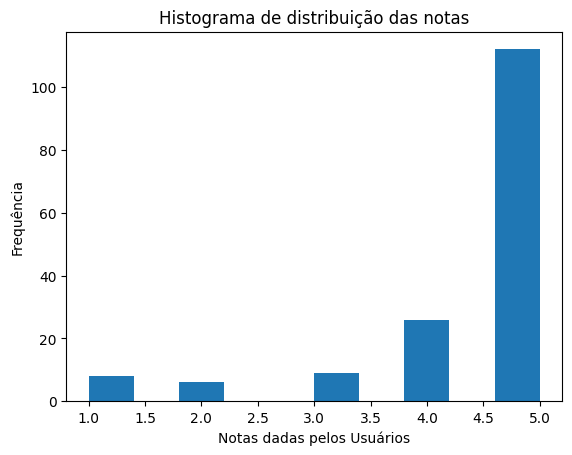

In [47]:
notas_app = df['rating'] #variavel que vai armazenas as notas do aplicativo

plt.hist(notas_app) #plot histograma
plt.xlabel('Notas dadas pelos Usuários')
plt.ylabel('Frequência')
plt.title('Histograma de distribuição das notas')
plt.show()


In [49]:
notas_app.value_counts()

rating
5    112
4     26
3      9
1      8
2      6
Name: count, dtype: int64

O gráfico demonstra uma satisfação extremamente elevada, com a grande maioria das avaliações concentradas na nota máxima (5) e pouquíssimas notas baixas. Isso indica uma aceitação muito positiva por parte dos usuários em relação ao item avaliado. 

Quanto a soma de valores de cada nota vemos que a nota 5 ainda sim é muito superior a nota 4 e demais.

##  Correlação entre Ratings e Números de curtidas por review

Para analisar essa correlação, usarei um scatter plot. O objetivo é verificar se a comunidade concorda com as críticas reportadas. Por exemplo, uma avaliação de 1 estrela com muitas curtidas sugere um bug crítico que afeta diversos usuários. Já se houver poucas curtidas, é provável que seja um erro isolado de apenas um usuário

Text(0.5, 1.0, 'Dispersão: Idade vs Notas')

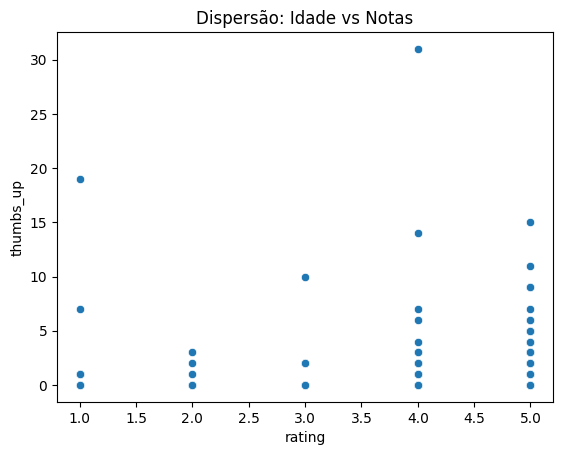

In [53]:
curtidas_review = df['thumbs_up']

sns.scatterplot(data = df, x = notas_app , y= curtidas_review) #eixo x sendo as notas e eixo y sendo as curtidas em review

plt.title("Dispersão: Idade vs Notas")

- A análise do gráfico de dispersão revela que, embora a aplicação seja predominantemente bem avaliada, existem situações específicas de forte concordância da comunidade: destaca-se um ponto isolado na nota mínima (1 estrela) com elevado número de curtidas, sugerindo um bug crítico reportado e confirmado por diversos usuários, enquanto um comentário na nota 4 com engajamento ainda maior aponta para um consenso sobre um feedback relevante ou falha menos severa que, apesar de notável, não compromete a satisfação geral positiva do produto.